## In this notebook we will focus on preprocessing to drop as many columns at the begining. We will compute statistics, compare the train and test dataset. Drop some columns that don't match. Moreover we will calculate correlation and check outliers so that the model is not affected that much by them. 

Most of the things are outlined in this blog https://neptune.ai/blog/tabular-data-binary-classification-tips-and-tricks-from-5-kaggle-competitions#:~:text=%2A%20Stratified%20KFold%20cross,Time%20Series%20split%20validation

# First of all let's check some features statistics in both train and test data. Let's compare top 10 of them

In [1]:
import pandas as pd
import numpy as np

x_train = pd.read_csv('data/x_train.txt', sep=r'\s+', header=None)
y_train = pd.read_csv('data/y_train.txt', sep=r'\s+', header=None)[0]
x_test  = pd.read_csv('data/x_test.txt',  sep=r'\s+', header=None)

stats = []
for i in x_train.columns:
    t_mean = x_train[i].mean()
    s_mean = x_test[i].mean()
    t_var  = x_train[i].var()
    s_var  = x_test[i].var()
    stats.append({
        'feature':             i,
        'train_mean':          t_mean,
        'test_mean':           s_mean,
        'mean_diff':           s_mean - t_mean,
        'train_variance':      t_var,
        'test_variance':       s_var,
        'variance_ratio':      (s_var / t_var) if t_var>0 else np.nan,
        'corr_with_target':    x_train[i].corr(y_train)
    })

summary_df = pd.DataFrame(stats).set_index('feature')

print(summary_df.head(10))



         train_mean  test_mean  mean_diff  train_variance  test_variance  \
feature                                                                    
0         15.560411  15.507078  -0.053333       18.730704      17.260227   
1         12.650449  12.655507   0.005058       14.317654      13.704232   
2         27.750084  27.736016  -0.014067       48.258792      44.019127   
3         18.796808  18.825133   0.028325       24.323544      22.632589   
4         19.071302  18.995343  -0.075959       27.471500      25.135808   
5         11.820110  11.769083  -0.051027       13.312292      12.482966   
6         19.365360  19.355964  -0.009395       28.260874      25.857634   
7         15.602632  15.517396  -0.085235       19.669401      18.001512   
8         14.163618  14.233636   0.070018       19.810112      19.051235   
9         15.989661  16.041487   0.051826       22.978933      22.298445   

         variance_ratio  corr_with_target  
feature                                    

# In this part we will look at distribution mismatches and test using Komogorov-Smirnov test. Moreover, we will look at outliers and cap them to 1st and 99th percentiles and display mismatches

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp



q_low  = x_train.quantile(0.01)
q_high = x_train.quantile(0.99)

stats = []
for col in x_train.columns:
    ks_stat, ks_p = ks_2samp(x_train[col], x_test[col])
    train_outliers = ((x_train[col] < q_low[col]) | (x_train[col] > q_high[col])).sum()
    test_outliers  = ((x_test[col]  < q_low[col]) | (x_test[col]  > q_high[col])).sum()
    stats.append({
        'feature':        col,
        'ks_stat':        ks_stat,
        'ks_pvalue':      ks_p,
        'train_outliers': train_outliers,
        'test_outliers':  test_outliers,
        'train_q01':      q_low[col],
        'train_q99':      q_high[col],
        'train_min':      x_train[col].min(),
        'train_max':      x_train[col].max(),
        'test_min':       x_test[col].min(),
        'test_max':       x_test[col].max(),
    })

stats_df = pd.DataFrame(stats).set_index('feature')

print("KS statistics for top 10 ks_stat features:")
print(stats_df.sort_values('ks_stat', ascending=False).head(10))

x_train_capped = x_train.clip(lower=q_low, upper=q_high, axis=1)
x_test_capped  = x_test.clip( lower=q_low, upper=q_high, axis=1)

ks_after = []
for col in x_train.columns:
    ks2, p2 = ks_2samp(x_train_capped[col], x_test_capped[col])
    ks_after.append(ks2)
stats_df['ks_after_capping'] = ks_after

print("\nKS statistics for top 10 ks_stat features: after capping:")
top10 = stats_df.sort_values('ks_stat', ascending=False).head(10)
print(top10[['ks_stat','ks_after_capping']])


KS statistics for top 10 ks_stat features:
         ks_stat  ks_pvalue  train_outliers  test_outliers  train_q01  \
feature                                                                 
428       0.0426   0.000229             100            112   2.665452   
130       0.0368   0.002291             100            105  -2.249431   
107       0.0368   0.002291             100             97  -2.315544   
135       0.0354   0.003798             100            110  -2.354010   
394       0.0340   0.006174             100            156   0.012440   
303       0.0338   0.006607             100             76   0.008643   
296       0.0336   0.007068             100             92   0.022230   
252       0.0324   0.010504             100            108   0.025570   
34        0.0314   0.014451             100             99  -2.257608   
266       0.0308   0.017417             100            144   0.030595   

         train_q99  train_min  train_max  test_min   test_max  
feature         

# Now in this part recalculate ks test, use QuantileTransformer to cap the data. Moreover Do Adversarial Validation using Random Forest to distinguish between test and train and drop some of the features that mismatch

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


q_low, q_high = x_train.quantile(0.01), x_train.quantile(0.99)

stats = []
for col in x_train.columns:
    ks_stat, _ = ks_2samp(x_train[col], x_test[col])
    test_out = ((x_test[col] < q_low[col]) | (x_test[col] > q_high[col])).sum()
    stats.append({'feature': col, 'ks_stat': ks_stat, 'test_outliers': test_out})
stats_df = pd.DataFrame(stats).set_index('feature')

ks_thresh = 0.035
outlier_thresh = 120
flagged = stats_df[
    (stats_df['ks_stat'] >= ks_thresh) |
    (stats_df['test_outliers'] > outlier_thresh)
].index.tolist()
print(f"Flagged features (KS ≥ {ks_thresh} or test_outliers > {outlier_thresh}):\n{flagged}\n")

qt = QuantileTransformer(output_distribution='uniform', random_state=0)
combined = pd.concat([x_train[flagged], x_test[flagged]], axis=0)
qt.fit(combined)

x_train_qt = x_train.copy()
x_test_qt  = x_test.copy()
x_train_qt[flagged] = qt.transform(x_train[flagged])
x_test_qt[flagged]  = qt.transform(x_test[flagged])

X_adv = pd.concat([x_train_qt[flagged], x_test_qt[flagged]], axis=0)
y_adv = np.concatenate([np.zeros(len(x_train_qt)), np.ones(len(x_test_qt))])

X_tr, X_val, y_tr, y_val = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=0, stratify=y_adv
)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_tr, y_tr)

y_prob = rf.predict_proba(X_val)[:,1]
print(f"Adversarial AUC: {roc_auc_score(y_val, y_prob):.3f}, "
      f"Accuracy: {accuracy_score(y_val, rf.predict(X_val)):.3f}\n")

importances = pd.Series(rf.feature_importances_, index=flagged).sort_values(ascending=False)
print("Top 10 adversarial-important features:")
print(importances.head(10), "\n")

new_stats = []
for col in flagged:
    ks2, _ = ks_2samp(x_train_qt[col], x_test_qt[col])
    new_stats.append({'feature': col, 'ks_after': ks2})
new_df = pd.DataFrame(new_stats).set_index('feature')
print("KS after QuantileTransform:")
print(new_df, "\n")

to_drop = new_df[new_df['ks_after'] > ks_thresh].index.tolist()
keep_after = [f for f in flagged if f not in to_drop]
print(f"Features to drop (ks_after > {ks_thresh}): {to_drop}")
print(f"Features to keep: {keep_after}\n")

x_train_processed = x_train_qt.drop(columns=to_drop)
x_test_processed  = x_test_qt.drop(columns=to_drop)

print(f"Final shapes → x_train: {x_train_processed.shape}, x_test: {x_test_processed.shape}")


Flagged features (KS ≥ 0.035 or test_outliers > 120):
[11, 20, 24, 44, 47, 50, 55, 107, 114, 117, 121, 122, 123, 127, 130, 133, 135, 163, 175, 177, 184, 188, 193, 198, 204, 214, 225, 232, 244, 253, 264, 266, 279, 342, 343, 354, 388, 390, 394, 399, 404, 413, 426, 428, 430, 434, 439, 464]

Adversarial AUC: 0.501, Accuracy: 0.490

Top 10 adversarial-important features:
130    0.022881
107    0.022392
428    0.022245
388    0.022131
135    0.021990
184    0.021944
117    0.021707
394    0.021654
204    0.021605
232    0.021597
dtype: float64 

KS after QuantileTransform:
         ks_after
feature          
11         0.0078
20         0.0186
24         0.0134
44         0.0206
47         0.0164
50         0.0206
55         0.0242
107        0.0368
114        0.0084
117        0.0218
121        0.0184
122        0.0178
123        0.0180
127        0.0196
130        0.0368
133        0.0172
135        0.0354
163        0.0120
175        0.0176
177        0.0106
184        0.0180
188        0

# Now let's chech Variance Threshold that are near-zero. Moreover, remove highly correlated features if there exist such. Scale the remaining features using both train and test data

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.feature_selection import VarianceThreshold


sel = VarianceThreshold(threshold=1e-5)
sel.fit(x_train_processed)
keep_var = x_train_processed.columns[sel.get_support()]
drop_var = [c for c in x_train_processed.columns if c not in keep_var]
print("Dropped for near-zero variance:", drop_var)
x_train_var = x_train_processed[keep_var].copy()
x_test_var  = x_test_processed[keep_var].copy()

corr = x_train_var.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Dropped for high correlation:", drop_corr)
x_train_corr = x_train_var.drop(columns=drop_corr).copy()
x_test_corr  = x_test_var.drop(columns=drop_corr).copy()

scaler = StandardScaler()
combined = pd.concat([x_train_corr, x_test_corr], axis=0)
scaler.fit(combined)

x_train_final = pd.DataFrame(
    scaler.transform(x_train_corr),
    columns=x_train_corr.columns,
    index=x_train_corr.index
)
x_test_final = pd.DataFrame(
    scaler.transform(x_test_corr),
    columns=x_test_corr.columns,
    index=x_test_corr.index
)

print("Final shapes →", x_train_final.shape, x_test_final.shape)


Dropped for near-zero variance: []
Dropped for high correlation: [7]
Final shapes → (5000, 495) (5000, 495)


# Now we will create our net_score that we want to minimize, do an optuna search to find best parameters of C and threshold. After that use SHAP to rank features by importance. Also do the Bootstrap stability check

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import shap


def net_score(y_true, y_pred, n_features):
    acc = accuracy_score(y_true, y_pred)
    return 10 * acc * len(y_true) - 200 * n_features

def objective(trial):
    C = trial.suggest_loguniform('C', 0.001, 0.01)
    threshold = trial.suggest_float('threshold', 0.4, 0.6)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    
    for train_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[train_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LogisticRegression(
            penalty='l1', solver='saga', C=C,
            max_iter=10000, random_state=0
        )
        model.fit(X_tr, y_tr)
        
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        n_feats = np.count_nonzero(model.coef_)
        
        scores.append(net_score(y_val, preds, n_feats))
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_C = best_params['C']
best_threshold = best_params['threshold']
print(f"Best params C: {best_C:.5f}, threshold: {best_threshold:.2f}")

final_model = LogisticRegression(
    penalty='l1', solver='saga', C=best_C,
    max_iter=10000, random_state=0
)
final_model.fit(x_train_final, y_train)

test_probs = final_model.predict_proba(x_test_final)[:, 1]
y_test_pred = (test_probs >= best_threshold).astype(int)

explainer = shap.LinearExplainer(
    final_model,
    x_train_final,
    feature_perturbation="interventional"
)
shap_values = explainer.shap_values(x_train_final)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_imp = pd.Series(mean_abs_shap, index=x_train_final.columns)
shap_imp = shap_imp.sort_values(ascending=False)
print("\nTop 10 features by mean |SHAP|:")
print(shap_imp.head(10))

B = 100
rng = np.random.RandomState(0)
feat_count = pd.Series(0, index=x_train_final.columns)

for i in range(B):
    idx = rng.choice(len(x_train_final), len(x_train_final), replace=True)
    Xb, yb = x_train_final.iloc[idx], y_train.iloc[idx]
    m = LogisticRegression(
        penalty='l1', solver='saga', C=best_C,
        max_iter=10000, random_state=i
    )
    m.fit(Xb, yb)
    sel = x_train_final.columns[m.coef_[0] != 0]
    feat_count[sel] += 1

stability = (feat_count / B).sort_values(ascending=False)
print("\nBootstrap selection frequency (top 10):")
print(stability.head(10))

[I 2025-05-29 00:52:28,121] A new study created in memory with name: no-name-5a0a16ac-4988-4df8-ba5c-47e5ee007f28
C:\Users\hucu\AppData\Local\Temp\ipykernel_23856\2709083352.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.001, 0.01)
[I 2025-05-29 00:52:29,339] Trial 0 finished with value: 6830.0 and parameters: {'C': 0.004522437918151069, 'threshold': 0.48978592450321723}. Best is trial 0 with value: 6830.0.
C:\Users\hucu\AppData\Local\Temp\ipykernel_23856\2709083352.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.001, 0.01)
[I 2025-05-29 00:52:30,453] Trial 1 finished with value: 5922.0 a

Best params → C: 0.00459, threshold: 0.48


c:\Users\hucu\Desktop\AMLProject2\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)



Top 10 features by mean |SHAP|:
2     0.501693
6     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
dtype: float64

Bootstrap selection frequency (top 10):
2      1.00
6      0.53
414    0.04
5      0.03
8      0.01
11     0.00
12     0.00
13     0.00
14     0.00
15     0.00
dtype: float64


# Now with the SHAP and Bootstrap we have distinguished two features that stand out among the rest hence we will check only two subsets 2 and [2, 6] to chech the net score of those with Kfold validation 

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score



def evaluate_subset(feats):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    all_true, all_prob = [], []
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr = x_train_final.iloc[tr_idx][feats]
        y_tr = y_train.iloc[tr_idx]
        X_val = x_train_final.iloc[val_idx][feats]
        y_val = y_train.iloc[val_idx]
        
        model = LogisticRegression(penalty='l1', solver='saga',
                                   C=best_C, max_iter=10000, random_state=0)
        model.fit(X_tr, y_tr)
        
        all_true.append(y_val.values)
        all_prob.append(model.predict_proba(X_val)[:,1])
        
    all_true = np.concatenate(all_true)
    all_prob = np.concatenate(all_prob)
    
    best_net, best_thr = -np.inf, 0.5
    for thr in np.linspace(0.1, 0.9, 81):
        preds = (all_prob >= thr).astype(int)
        net = net_score(all_true, preds, len(feats))
        if net > best_net:
            best_net, best_thr = net, thr
    return best_net, best_thr

candidates = [[2], [2, 6]]

best_net = -np.inf
winning_subset = None
winning_thr = None

for subset in candidates:
    net, thr = evaluate_subset(subset)
    print(f"Subset {subset}: CV net-score = {net:.1f} @ threshold {thr:.2f}")
    if net > best_net:
        best_net, winning_subset, winning_thr = net, subset, thr

print(f"\nWinning subset: {winning_subset} with net-score {best_net:.1f} @ threshold {winning_thr:.2f}")

final = LogisticRegression(penalty='l1', solver='saga', C=best_C,
                           max_iter=10000, random_state=0)
final.fit(x_train_final[winning_subset], y_train)

y_test_pred = (final.predict_proba(x_test_final[winning_subset])[:,1] >= winning_thr).astype(int)

print(f"Final model trained with features {winning_subset}; test predictions ready.")


Subset [2]: CV net‐score = 35130.0 @ threshold 0.49
Subset [2, 6]: CV net‐score = 34940.0 @ threshold 0.48

Winning subset: [2] with net‐score 35130.0 @ threshold 0.49
Final model trained with features [2]; test predictions ready.


# Create histogram to check distributions of these two to compare them. 

Feature 2 – Training Set Statistics:
{'mean': np.float64(27.75008354959396), 'median': np.float64(27.1105612298134), 'std': np.float64(6.946854798411643), 'min': np.float64(9.36101575097885), 'max': np.float64(58.1441483368565)}

Feature 2 – Test Set Statistics:
{'mean': np.float64(27.736016441053316), 'median': np.float64(27.27966727062615), 'std': np.float64(6.634691184525816), 'min': np.float64(10.1794240572433), 'max': np.float64(59.9774966977393)}


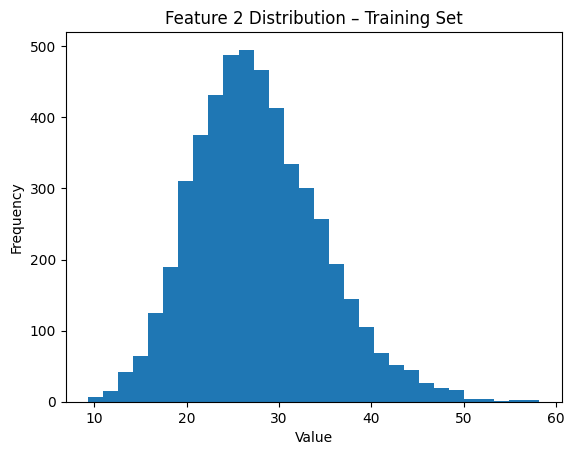

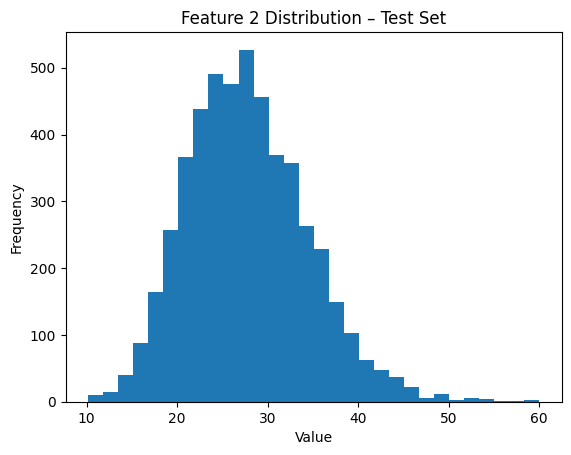

In [ ]:
import matplotlib.pyplot as plt


feat = 2

train_stats = {
    'mean':   x_train[feat].mean(),
    'median': x_train[feat].median(),
    'std':    x_train[feat].std(),
    'min':    x_train[feat].min(),
    'max':    x_train[feat].max()
}
test_stats = {
    'mean':   x_test[feat].mean(),
    'median': x_test[feat].median(),
    'std':    x_test[feat].std(),
    'min':    x_test[feat].min(),
    'max':    x_test[feat].max()
}

print("Feature 2 – Training Set Statistics:")
print(train_stats)
print("\nFeature 2 – Test Set Statistics:")
print(test_stats)

plt.figure()
plt.hist(x_train[feat], bins=30)
plt.title('Feature 2 Distribution – Training Set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(x_test[feat], bins=30)
plt.title('Feature 2 Distribution – Test Set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
